In [22]:
import pandas as pd
from sklearn.metrics import (
    accuracy_score, roc_auc_score, confusion_matrix,
    precision_score, recall_score
)
import mlflow
import mlflow.sklearn
import numpy as np
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt 
from matplotlib.pyplot import show



In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Dense,Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam


In [24]:
df1 = pd.read_csv("C:/ML_AI/loan/loan_acceptance_using_multiple-algorithm/data/one_hot_encode/train_processed_data.csv")

df2= pd.read_csv("C:/ML_AI/loan/loan_acceptance_using_multiple-algorithm/data/one_hot_encode/test_processed_data.csv")

In [25]:
xtrain=df1.drop(labels=["loan_status"],axis=1)
ytrain=df1[["loan_status"]]

In [26]:
xtest=df2.drop(labels=["loan_status"],axis=1)
ytest=df2[["loan_status"]]

In [27]:
rus = RandomUnderSampler(sampling_strategy=1.0, random_state=42)  
X_res, y_res = rus.fit_resample(xtrain, ytrain)

In [ ]:
mlflow.set_tracking_uri("file:///C:/ML_AI/loan/loan_acceptance_using_multiple-algorithm/mlruns")
mlflow.set_experiment("loan_acceptance_logreg_Neural_Network") 

with mlflow.start_run(run_name="NeuralNetwork_run_one_hot_encode_latency"):

    
    model = Sequential([
        Input(shape=(xtrain.shape[1],)),
        Dense(64, activation="relu", kernel_regularizer=l2(0.01)),
        Dropout(0.4),
        Dense(32, activation="relu", kernel_regularizer=l2(0.01)),
        Dropout(0.3),
        Dense(16, activation="relu", kernel_regularizer=l2(0.01)),
        Dropout(0.2),
        Dense(8, activation="relu", kernel_regularizer=l2(0.01)),
        Dense(1, activation="sigmoid")
    ])


    model.compile(
        loss="binary_crossentropy",
        optimizer=Adam(learning_rate=0.001),
        metrics=["accuracy", "Precision", "Recall", "AUC"]
    )


    es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)


    mlflow.log_params({
        "optimizer": "Adam",
        "learning_rate": 0.001,
        "loss": "binary_crossentropy",
        "l2_reg": 0.01,
        "dropout": "0.4/0.3",
        "epochs": 100,
        "patience": 5,
        "batch_size": 32
    })


    hist = model.fit(
        xtrain, ytrain,
        epochs=100,
        batch_size=32,
        validation_split=0.2,
        callbacks=[es],
        verbose=1
    )

    y_prob_train = model.predict(xtrain).ravel()
    y_pred_train = (y_prob_train >= 0.5).astype(int)

    acc_train = accuracy_score(ytrain, y_pred_train)
    prec_train = precision_score(ytrain, y_pred_train)
    rec_train = recall_score(ytrain, y_pred_train)
    auc_train = roc_auc_score(ytrain, y_prob_train)


    y_prob_test = model.predict(xtest).ravel()
    y_pred_test = (y_prob_test >= 0.5).astype(int)

    acc_test = accuracy_score(ytest, y_pred_test)
    prec_test = precision_score(ytest, y_pred_test)
    rec_test = recall_score(ytest, y_pred_test)
    auc_test = roc_auc_score(ytest, y_prob_test)

    mlflow.log_metrics({
    
        "train_accuracy": acc_train,
        "train_precision": prec_train,
        "train_recall": rec_train,
        "train_auc": auc_train,


        "test_accuracy": acc_test,
        "test_precision": prec_test,
        "test_recall": rec_test,
        "test_auc": auc_test
    })

 
    mlflow.keras.log_model(model, artifact_path="model")


    print("✅ Model logged successfully in MLflow!")
    print(f"Train -> Acc={acc_train:.3f} | Prec={prec_train:.3f} | Rec={rec_train:.3f} | AUC={auc_train:.3f}")
    print(f"Test  -> Acc={acc_test:.3f} | Prec={prec_test:.3f} | Rec={rec_test:.3f} | AUC={auc_test:.3f}")


Epoch 1/100
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8710 - Precision: 0.7006 - Recall: 0.4153 - accuracy: 0.8911 - loss: 0.4107 - val_AUC: 0.9020 - val_Precision: 0.7940 - val_Recall: 0.5279 - val_accuracy: 0.9128 - val_loss: 0.2741
Epoch 2/100
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9014 - Precision: 0.7757 - Recall: 0.5292 - accuracy: 0.9108 - loss: 0.2698 - val_AUC: 0.9034 - val_Precision: 0.8000 - val_Recall: 0.5689 - val_accuracy: 0.9179 - val_loss: 0.2615
Epoch 3/100
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9036 - Precision: 0.7911 - Recall: 0.5556 - accuracy: 0.9155 - loss: 0.2608 - val_AUC: 0.9069 - val_Precision: 0.8026 - val_Recall: 0.5905 - val_accuracy: 0.9206 - val_loss: 0.2559
Epoch 4/100
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9067 - Precision: 0.7958 - Recall: 0.5623 - accuracy: 0.9168 - loss: 0.2561 - val_AUC: 0.9065 - val_Precision: 0.8246 - val_Recall: 0.5637 - val_accuracy: 0.9204 - val_loss: 0.2555
Epoch 5/100
1173/117

2025/11/12 19:40:37 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/12 19:40:37 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/11/12 19:40:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Model logged successfully in MLflow!
Train -> Acc=0.937 | Prec=0.872 | Rec=0.653 | AUC=0.924
Test  -> Acc=0.938 | Prec=0.871 | Rec=0.655 | AUC=0.930


In [ ]:
# reducing layers

In [ ]:
mlflow.set_tracking_uri("file:///C:/ML_AI/loan/loan_acceptance_using_multiple-algorithm/mlruns")
mlflow.set_experiment("loan_acceptance_logreg_Neural_Network") 

with mlflow.start_run(run_name="NeuralNetwork_run_one_hot_encode_latency"):

    
    model = Sequential([
        Input(shape=(xtrain.shape[1],)),
        Dense(64, activation="relu", kernel_regularizer=l2(0.01)),
        Dropout(0.4),
        Dense(32, activation="relu", kernel_regularizer=l2(0.01)),
        Dense(1, activation="sigmoid")
    ])


    model.compile(
        loss="binary_crossentropy",
        optimizer=Adam(learning_rate=0.001),
        metrics=["accuracy", "Precision", "Recall", "AUC"]
    )


    es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)


    mlflow.log_params({
        "optimizer": "Adam",
        "learning_rate": 0.001,
        "loss": "binary_crossentropy",
        "l2_reg": 0.01,
        "dropout": "0.4/0.3",
        "epochs": 100,
        "patience": 5,
        "batch_size": 32
    })


    hist = model.fit(
        xtrain, ytrain,
        epochs=100,
        batch_size=32,
        validation_split=0.2,
        callbacks=[es],
        verbose=1
    )

    y_prob_train = model.predict(xtrain).ravel()
    y_pred_train = (y_prob_train >= 0.5).astype(int)

    acc_train = accuracy_score(ytrain, y_pred_train)
    prec_train = precision_score(ytrain, y_pred_train)
    rec_train = recall_score(ytrain, y_pred_train)
    auc_train = roc_auc_score(ytrain, y_prob_train)


    y_prob_test = model.predict(xtest).ravel()
    y_pred_test = (y_prob_test >= 0.5).astype(int)

    acc_test = accuracy_score(ytest, y_pred_test)
    prec_test = precision_score(ytest, y_pred_test)
    rec_test = recall_score(ytest, y_pred_test)
    auc_test = roc_auc_score(ytest, y_prob_test)

    mlflow.log_metrics({
    
        "train_accuracy": acc_train,
        "train_precision": prec_train,
        "train_recall": rec_train,
        "train_auc": auc_train,


        "test_accuracy": acc_test,
        "test_precision": prec_test,
        "test_recall": rec_test,
        "test_auc": auc_test
    })

 
    mlflow.keras.log_model(model, artifact_path="model")


    print("✅ Model logged successfully in MLflow!")
    print(f"Train -> Acc={acc_train:.3f} | Prec={prec_train:.3f} | Rec={rec_train:.3f} | AUC={auc_train:.3f}")
    print(f"Test  -> Acc={acc_test:.3f} | Prec={prec_test:.3f} | Rec={rec_test:.3f} | AUC={auc_test:.3f}")

<function matplotlib.pyplot.show(close=None, block=None)>

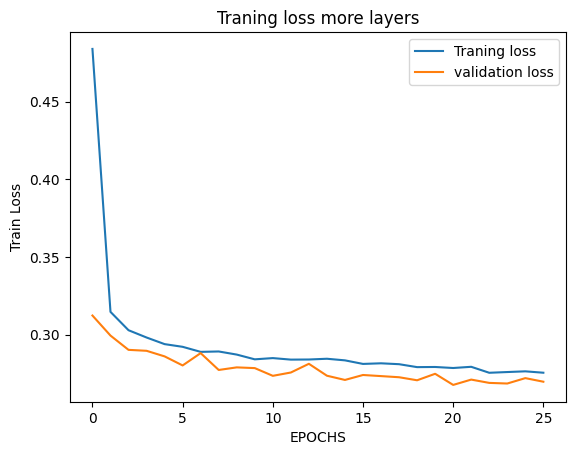

In [29]:
plt.plot(hist.history["loss"],label="Traning loss")
plt.plot(hist.history["val_loss"],label="validation loss")
plt.xlabel("EPOCHS")
plt.ylabel("Train Loss")
plt.title("Traning loss more layers")
plt.legend()
plt.show